#### install & restart session

In [1]:
!pip install datasets

   ---------------------------------------- 0.0/542.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/542.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/542.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/542.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/542.0 kB ? eta -:--:--
   ---------- --------------------------- 143.4/542.0 kB 532.5 kB/s eta 0:00:01
   -------------- ----------------------- 204.8/542.0 kB 692.4 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
   ------------------- ------------------ 276.5/542.0 kB 850.6 kB/s eta 0:00:01
 

In [2]:
pip install transformers[torch]

^C
Note: you may need to restart the kernel to use updated packages.


     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     -------- ------------------------------ 30.7/138.0 kB 1.4 MB/s eta 0:00:01
     -------- ------------------------------ 30.7/138.0 kB 1.4 MB/s eta 0:00:01
     ---------- -------------------------- 41.0/138.0 kB 393.8 kB/s eta 0:00:01
     ------------------- ----------------- 71.7/138.0 kB 359.3 kB/s eta 0:00:01
     ------------------- ----------------- 71.7/138.0 kB 359.3 kB/s eta 0:00:01
     ------------------- ----------------- 71.7/138.0 kB 359.3 kB/s eta 0:00:01
     ------------------- ----------------- 71.7/138.0 kB 359.3 kB/s eta 0:00:01
     ------------------- ----------------- 71.7/138.0 kB 359.3 kB/s eta 0:0

In [ ]:
!pip install accelerate -U

In [ ]:
import accelerate
accelerate.__version__

'0.29.3'

In [5]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=07a890040cdc6404e3dd1cfbf407e18b688e9a11fe5fbe70d52c5ca3260384e8
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Datasets prep

create two datasets: train and evaluation with ids, tokens, ner_tags as columns

### Data import

extract the text data to tokenize it apart

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json

with open(r"/content/drive/MyDrive/ner_data/NER_TRAIN_JUDGEMENT.json") as file:
    json_data = json.load(file)

text_data = []
for line in json_data:
    text_data.append(line['data']['text'])

In [ ]:
len(text_data)

9435

In [3]:
import json
with open(r"/content/drive/MyDrive/ner_data/NER_DEV_PREAMBLE.json") as file:
    dev_data = json.load(file)
print(len(dev_data))

125


In [4]:
import re
def clean_dev_data(text_data):
    replacements = [
        (r'\.{2,}', ''),
        (r'=+', ''),
        (r'\-{2,}', ''),
        (r'\xad', ''),
        (r'\n\n', '\n'),
        (r'\t', ' '),
        # (r'\s{2,}', ' '),
        (r'\xa0', ' ')]

    for old, new in replacements:
      text_data = re.sub(old, new, text_data)
    return text_data

dev_text_data = []
for line in dev_data:
    dev_text_data.append(clean_dev_data(line['data']['text']))

In [5]:
def get_new_position(old_text, new_text, pos):
  #a function that'll allow to find the position in the new cleaned text using the position in the raw text given in annotations

  if new_text[pos.start:pos.stop-1] == old_text[pos.start:pos.stop-1]:
    return pos

  else: # we actually need to update the pos

    special_entity = old_text[pos]
    in_old_text = [m.start() for m in re.finditer(re.escape(special_entity), old_text)]
    in_new_text = [m.start() for m in re.finditer(re.escape(clean_dev_data(special_entity)), new_text)]


    if len(in_new_text) != len(in_old_text):  #written differently              #still need a generalisation
      if len(in_new_text) == 2: #recherche dichotomie
        #look for the clean word in clean(text[:pos.start], was it found before it or no?
        if clean_dev_data(special_entity) not in clean_dev_data(old_text[:pos.start]): #
          in_new_text = [in_new_text[0]]

        else:
          in_new_text = [in_new_text[1]]

      else:
        print("\n not same len")
        print('\t special_entity: ', special_entity)
        print('in_old_text: ', in_old_text, '\t in_new_text: ',in_new_text)


    all_occ = dict(zip(in_old_text,in_new_text))
    # print('all_occ: ', all_occ)

    start = all_occ[pos.start]

    end = start+len(clean_dev_data(old_text[pos]))#-1

    return slice(start,end)


## use_cases
# indice = 113
# pos = slice(136, 152)
# pos = slice(1356, 1372)
# pos_test = get_new_position(dev_data[indice]['data']['text'],dev_text_data[indice], pos )
# print('old_pos: ', pos)
# print('new_pos', pos_test)
# print(dev_data[indice]['data']['text'][pos])  #len split != 1
# print(dev_data[indice]['data']['text'][pos] == dev_text_data[indice][pos_test])

Now to deal with the case we have one, two occurences shown differently, we can prepare the function to give us the

### model and tokenizer

In [6]:
model = 'dslim/bert-base-NER'
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### tokenize train data

In [ ]:
tokenized = tokenizer(text_data,  is_split_into_words = False, return_offsets_mapping = True, add_special_tokens = True, padding = 'max_length', max_length=512, stride=128, return_overflowing_tokens=True,
 )  #when text is not splitted, the positions in str are accurate

tokens = [tokenizer.convert_ids_to_tokens(tokenizedx) for tokenizedx in tokenized.input_ids]

### tokenization of the dev data without truncation

In [ ]:
dev_tokenized = tokenizer(dev_text_data,  is_split_into_words = False,  return_offsets_mapping = True, add_special_tokens = True, padding = 'max_length', max_length=512, stride=128, return_overflowing_tokens=True, )  #when text is not splitted, the positions are accurate

dev_tokens = [tokenizer.convert_ids_to_tokens(tokenizedx) for tokenizedx in dev_tokenized.input_ids]

#### check indices for pad & overflowing tokens

In [ ]:
num_padded = 0
for indice in range(len(dev_tokenized['input_ids'])):
  if len(dev_tokenized['input_ids'][indice]) > 512:
    print(indice, ' : ', len(dev_tokenized['input_ids'][indice]))
  if dev_tokenized['offset_mapping'][indice][dev_tokenized['offset_mapping'][indice].index((max(dev_tokenized['offset_mapping'][indice])))] != dev_tokenized['offset_mapping'][indice][-2]:
    num_padded += 1

print('\n num_padded = ', num_padded, '/', len(dev_tokenized['input_ids']), len(dev_tokenized['input_ids'])-num_padded)

6  :  546
16  :  1087
17  :  594
32  :  843
37  :  666
42  :  1120
44  :  621
48  :  836
72  :  540
79  :  904
89  :  848
103  :  668
114  :  675
118  :  1051
120  :  811
121  :  677
122  :  804

 num_padded =  108 / 125 17


### tokenization of the dev data with truncation

In [7]:
dev_tokenized = tokenizer(dev_text_data,  is_split_into_words = False,  return_offsets_mapping = True, add_special_tokens = True, padding = 'max_length', max_length=512, stride=128, truncation = True)# return_overflowing_tokens=True, )  #when text is not splitted, the positions are accurate

dev_tokens = [tokenizer.convert_ids_to_tokens(tokenizedx) for tokenizedx in dev_tokenized.input_ids]

## Dataset preparation

#### get token pos

In [8]:
def get_token_pos(mappers, start_str, end_str):
  for idx, (start, end) in enumerate(mappers):
    if idx<= mappers.index(max(mappers)):
        if start <= start_str:
            idx_start = idx
        if end == end_str:
            idx_end = idx+1
        if end < end_str:
            idx_end = idx+2

  pos = slice(idx_start, idx_end)
  return pos

# print(get_token_pos(tokenized["offset_mapping"][291],0,5 ))
# tokens[291][get_token_pos(tokenized["offset_mapping"][291],0,5 )]

### tester

the role of the following function is to test the functions in need after cleaning the data: the get_new_poition and get_token_position
 </br>
<!--
whether the cleaning was done right to be later used for verification before allowing the update.
It checkes wether we  -->
the function was updated with the indices of where tokens exceed 512


In [9]:
def tester(indice, old_start, old_end):
  raw_text = dev_data[indice]['data']['text']
  special_entity = raw_text[old_start:old_end]
  clean_pos = get_new_position(raw_text,dev_text_data[indice], slice(old_start,old_end) )
  if  clean_dev_data(special_entity) != dev_text_data[indice][clean_pos] :
    print("special entity was not found in clean text:\t", indice,old_start, old_end )

  token_pos = get_token_pos(dev_tokenized["offset_mapping"][indice], clean_pos.start, clean_pos.stop)
  idx_over_512 = [6, 16, 17, 32, 37, 42, 44, 48, 72, 79, 89, 103, 114, 118, 120, 121, 122]

  if indice not in idx_over_512 and ''.join(dev_tokens[indice][token_pos]).replace('##', '')  != clean_dev_data(dev_data[indice]['data']['text'][old_start:old_end]).replace(' ', '').replace('\n', ''):#.replace('\xad', ''):
    print("token not found similar at: indice: ", indice, "\t old_start, old_end: ", old_start, old_end, "\t clean_pos:", clean_pos, "\t token_pos: ", token_pos )




  # if token_pos == slice(511,513):
  #   print("truncated at indice:\t ", indice, "old_start, old_end:\t", old_start, old_end, "clean_pos:\t", clean_pos )
  #token_pos != slice(511,513)
    # else:
  #   print('good: \t', special_entity, dev_tokens[indice][token_pos])
tester(16, 2159, 2186 )


## Token labels affectation

### On train data

#### affectation

In [ ]:
#initialize all tokens labels as 'O': other
tokens_labels = [['O' for mapper in tokenized["offset_mapping"][i]] for i in range(len(tokenized["offset_mapping"]))]

for indice in range(len(json_data)):                #then update based on the str position and the get token pos
  # print(indice)
  mappers = tokenized["offset_mapping"][indice]
  for annot in json_data[indice]['annotations']:    #list of all the entities that are part of the deal
    for result in annot['result']:
      deb_str = result['value']['start']
      fin_str = result['value']['end']
      pos = get_token_pos(mappers, deb_str, fin_str )
      label = result['value']['labels'][0]          #[0] to remove from list
      if tokens[indice][pos][0] == result['value']['text']:   #when the special entity == token, not cut
        # print(indice, pos, 'here')
        tokens_labels[indice][pos.start] = label
      else:
        tokens_labels[indice][pos.start] = 'B-'+label     #only put B- when there is an I-
        for x in range(pos.start+1, pos.stop):
          if x <len(tokens_labels[indice]):
            tokens_labels[indice][x] = 'I-'+label
  # print(indice, 'done')
          # print(get_token_pos(mappers, deb_str, fin_str ) )
          # print(tokens[indice][get_token_pos(mappers, deb_str, fin_str )], result['value']['labels'][0])
          # break

#### Set -100 for special characters cls and sep

In [ ]:
for indice in range(len(tokens_labels)):
  tokens_labels[indice][tokens[indice].index('[SEP]')] = -100
  tokens_labels[indice][tokens[indice].index('[CLS]')] = -100
  for idx in range(tokens[indice].index('[SEP]'), len(tokens[indice])):
    tokens_labels[indice][idx] = -100


#### random tokens_labels verif

In [ ]:
import random
indice = random.randint(0,len(tokenized["offset_mapping"]))
# indice = 0
print('indice: ', indice)

for annot in json_data[indice]['annotations']:
  for result in annot['result']:
    print((result['value']['start'], result['value']['end']), result['value']['text'], ' : ', result['value']['labels'][0])
print('\n ######### \n')

for i in range(tokenized["offset_mapping"][indice].index(max(tokenized["offset_mapping"][indice]))+5):
    # len(tokenized["offset_mapping"][indice])):#min(len(tokenized["offset_mapping"][indice]), len(tokens[indice]))):
  print(tokenized["offset_mapping"][indice][i], tokens[indice][i], tokens_labels[indice][i] )

indice:  2414
(45, 58) Supreme Court  :  COURT
(62, 126) AIR 1989 SC 1988 (SODAN SINGH Vs. NEW DELHI MUNICIPAL COMMITTEE)  :  PRECEDENT
(171, 180) Section 8  :  PROVISION
(188, 198) Kerala Act  :  STATUTE
(256, 272) Article 19(1)(g)  :  PROVISION

 ######### 

(0, 0) [CLS] -100
(0, 2) In O
(3, 6) the O
(7, 12) light O
(13, 15) of O
(16, 19) the O
(20, 32) observations O
(33, 37) made O
(38, 40) by O
(41, 44) the O
(45, 52) Supreme B-COURT
(53, 58) Court I-COURT
(59, 61) in O
(62, 64) AI B-PRECEDENT
(64, 65) ##R I-PRECEDENT
(66, 70) 1989 I-PRECEDENT
(71, 73) SC I-PRECEDENT
(74, 78) 1988 I-PRECEDENT
(79, 80) ( I-PRECEDENT
(80, 81) S I-PRECEDENT
(81, 83) ##OD I-PRECEDENT
(83, 85) ##AN I-PRECEDENT
(86, 87) S I-PRECEDENT
(87, 90) ##ING I-PRECEDENT
(90, 91) ##H I-PRECEDENT
(92, 93) V I-PRECEDENT
(93, 94) ##s I-PRECEDENT
(94, 95) . I-PRECEDENT
(96, 98) NE I-PRECEDENT
(98, 99) ##W I-PRECEDENT
(100, 102) DE I-PRECEDENT
(102, 103) ##L I-PRECEDENT
(103, 104) ##H I-PRECEDENT
(104, 105) ##I I-PRECE

### On dev data

#### affectation

In [10]:
dev_tokens_labels = [['O' for mapper in dev_tokenized["offset_mapping"][i]] for i in range(len(dev_tokenized["offset_mapping"]))]

num_updates = 0
num_fails = 0

for indice in range(len(dev_data)):
  # print('indice: \t', indice)
  for annot in dev_data[indice]['annotations']: #list of all the entities that are part of the deal
    for result in annot['result']:
        deb_str = result['value']['start']
        fin_str = result['value']['end']
        label = result['value']['labels'][0]
        # print('here', indice,  deb_str,fin_str )
        if tester(indice, deb_str, fin_str) == None:
          raw_text = dev_data[indice]['data']['text']
          special_entity = raw_text[deb_str:fin_str]
          # print(special_entity)
          clean_pos = get_new_position(raw_text,dev_text_data[indice], slice(deb_str,fin_str) )
          token_pos = get_token_pos(dev_tokenized["offset_mapping"][indice], clean_pos.start, clean_pos.stop)
          # dev_tokens_labels[indice][token_pos] = label
          # print(clean_pos, '\t, token_pos: \t', token_pos, 'label: \t', label )
          # print('toekn:', dev_tokens[indice][token_pos.start])
          dev_tokens_labels[indice][token_pos.start] = 'B-'+label
          for x in range(token_pos.start+1, token_pos.stop):
            if x <len(dev_tokens_labels[indice]):
              dev_tokens_labels[indice][x] = 'I-'+label
              num_updates+=1
            else:
              if x!=512 :
                print('not simillar,  \t', 'indice: \t', indice, '\t x: \t', x )
          # print(dev_tokens[indice][x])

        else:
          num_fails+=1

print('num_fails: \t', num_fails)
print('num_updates: \t', num_updates)


num_fails: 	 0
num_updates: 	 7075


#### Set -100 for special characters cls and sep

In [11]:
for indice in range(len(dev_tokens_labels)):
  dev_tokens_labels[indice][dev_tokens[indice].index('[CLS]')] = -100
  dev_tokens_labels[indice][dev_tokens[indice].index('[SEP]')] = -100
  for idx in range(dev_tokens[indice].index('[SEP]'), len(dev_tokens_labels[indice])):
    dev_tokens_labels[indice][idx] = -100


#### random tokens_labels verif

In [12]:
import random
indice = random.randint(0,len(dev_tokenized["offset_mapping"]))
# indice = 291
print('indice: ', indice)

for annot in dev_data[indice]['annotations']:
  for result in annot['result']:
    print((result['value']['start'], result['value']['end']), result['value']['text'], ' : ', result['value']['labels'][0])
print('\n ######### \n')

for i in range(dev_tokenized["offset_mapping"][indice].index(max(dev_tokenized["offset_mapping"][indice]))+4):
    # len(tokenized["offset_mapping"][indice])):#min(len(tokenized["offset_mapping"][indice]), len(tokens[indice]))):
  print(dev_tokenized["offset_mapping"][indice][i], dev_tokens[indice][i], dev_tokens_labels[indice][i] )

indice:  8
(25, 44) M. Seetharama Murti  :  JUDGE
(106, 120) Bhaskara Wines  :  PETITIONER
(143, 156) State of A.P.  :  RESPONDENT
(296, 314) K. Venugopal Reddy  :  LAWYER
(429, 442) N. Siva Reddy  :  LAWYER
(619, 637) M.Seetharama Murti  :  JUDGE

 ######### 

(0, 0) [CLS] -100
(0, 3) The O
(4, 7) Hon O
(7, 8) ' O
(8, 9) B O
(9, 11) ##le O
(12, 15) Sri O
(16, 23) Justice O
(25, 26) M B-JUDGE
(26, 27) . I-JUDGE
(28, 31) See I-JUDGE
(31, 34) ##tha I-JUDGE
(34, 38) ##rama I-JUDGE
(39, 41) Mu I-JUDGE
(41, 43) ##rt I-JUDGE
(43, 44) ##i I-JUDGE
(55, 56) W O
(56, 59) ##rit O
(60, 65) Petit O
(65, 68) ##ion O
(69, 71) No O
(71, 72) . O
(72, 75) 228 O
(75, 77) ##51 O
(78, 80) of O
(81, 85) 2018 O
(86, 88) 13 O
(88, 89) . O
(89, 91) 08 O
(91, 92) . O
(92, 96) 2018 O
(98, 99) M O
(99, 100) / O
(100, 101) s O
(101, 102) . O
(103, 104) B B-PETITIONER
(104, 107) ##has I-PETITIONER
(107, 111) ##kara I-PETITIONER
(112, 116) Wine I-PETITIONER
(116, 117) ##s I-PETITIONER
(118, 119) I O
(122, 123) . O
(

## Datasets creation

### labels lists

#### encode labels (str -> int)

In [ ]:
set_dev_tokens_labels = set([item for row in dev_tokens_labels for item in row])
set_tokens_labels = set([item for row in tokens_labels for item in row])
label_list = list(set_dev_tokens_labels.union(set_tokens_labels))

all_int_labels = {label: idx+1 for idx, label in enumerate(label_list)}
all_int_labels[-100] = -100
all_int_labels['O'] = 0

print(len(all_int_labels))
print(all_int_labels)

NameError: name 'tokens_labels' is not defined

#### train labels list

In [ ]:
import copy
int_tokens_labels = copy.deepcopy(tokens_labels)

for i in range(len(tokens_labels)):
  for j in range(len(tokens_labels[i])):
    int_tokens_labels[i][j] = all_int_labels[tokens_labels[i][j]]

#### dev labels list

In [22]:
import copy
int_dev_tokens_labels = copy.deepcopy(dev_tokens_labels)

for i in range(len(dev_tokens_labels)):
  for j in range(len(dev_tokens_labels[i])):
    int_dev_tokens_labels[i][j] = all_int_labels[dev_tokens_labels[i][j]]

### generate datasets

#### pip install

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


#### gen train dt

In [ ]:
def gen():
  i = 0
  for line in json_data: #'id':i, 'tokens': tokens[i],
    yield {'labels' : int_tokens_labels[i], 'input_ids': tokenized['input_ids'][i] , 'attention_mask': tokenized['attention_mask'][i]}
    i+=1

from datasets import Dataset
train_dt = Dataset.from_generator(gen)
train_dt


KeyboardInterrupt



In [ ]:
i = 0
for line in json_data: #'id': line['id'],
  test =  {'id':i, 'tokens': tokens[i], 'labels' : int_tokens_labels[i], 'input_ids': tokenized['input_ids'][i] , 'attention_mask': tokenized['attention_mask'][i]}
  i+=1
print(test.keys())
print(test['id'])
print(test['tokens'][0:2])
print(test['labels'][0:2])
# print(test[''])


In [ ]:
all_int_labels['O']

In [ ]:
len(int_tokens_labels)

#### gen dev dt

In [23]:
def dev_gen():
  i = 0
  for line in dev_data: #   'id':i,  'tokens': dev_tokens[i],
    yield {'labels' : int_dev_tokens_labels[i], 'input_ids': dev_tokenized['input_ids'][i] , 'attention_mask': dev_tokenized['attention_mask'][i]}
    i+=1

from datasets import Dataset
dev_dt = Dataset.from_generator(dev_gen)
dev_dt

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 125
})

#### datasets display

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))


In [ ]:
show_random_elements(train_dt, num_examples = 3)

,labels,input_ids,attention_mask
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 22, 23, 23, 23, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13, 17, 17, 17, 17, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]","[101, 1109, 21386, 23997, 1197, 1144, 1145, 8600, 1103, 2926, 1582, 15680, 1596, 17078, 21565, 1120, 2508, 13328, 1186, 10800, 23184, 17071, 1107, 1103, 23665, 1733, 1324, 3355, 1112, 153, 119, 160, 119, 123, 117, 1150, 1144, 2202, 1107, 1117, 8179, 118, 1107, 118, 2705, 1115, 117, 1103, 21386, 23997, 1197, 1108, 7815, 1113, 1765, 119, 4775, 119, 1387, 1111, 8670, 1104, 13996, 1105, 1119, 1125, 19073, 1116, 1104, 3372, 1106, 6012, 17981, 117, 7262, 1107, 2232, 1286, 2342, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,"[2, 2, 2, 2, 2, 2, 34, 8, 8, 8, 2, 2, 2, 2, 0, 31, 31, 31, 31, 31, 31, 31, 31, 13, 17, 17, 17, 17, 2, 28, 30, 30, 30, 30, 30, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]","[101, 113, 156, 1306, 1204, 119, 159, 4060, 1742, 18489, 114, 5274, 1299, 9380, 10382, 6750, 15575, 1302, 119, 24618, 1604, 120, 1368, 1512, 120, 5347, 120, 1387, 15795, 25354, 5412, 9392, 157, 1182, 20441, 117, 3560, 12654, 1111, 1103, 27414, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 39, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]","[101, 1109, 2021, 3878, 117, 6297, 9857, 1302, 1116, 119, 124, 1106, 126, 1303, 1394, 117, 8199, 117, 1103, 12987, 1104, 3284, 1230, 9724, 15795, 1760, 2723, 10136, 1964, 1611, 117, 24930, 28054, 119, 12987, 1104, 3284, 1230, 9724, 15795, 156, 2522, 24298, 3414, 1883, 1105, 17730, 2346, 1230, 9724, 15795, 12707, 22283, 5329, 117, 5733, 1940, 1116, 15232, 10294, 1906, 2310, 1118, 1136, 3525, 1103, 3062, 1106, 1435, 1149, 1196, 1142, 2031, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [ ]:
show_random_elements(dev_dt, num_examples = 3)


,labels,input_ids,attention_mask
0,"[2, 2, 2, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 34, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]","[101, 1130, 1109, 1693, 2031, 2096, 12247, 141, 7111, 3624, 1181, 3096, 1732, 14265, 1181, 1188, 1109, 1542, 1942, 1324, 2295, 2096, 1347, 117, 10351, 2577, 1109, 10942, 112, 139, 1513, 1828, 119, 3302, 148, 119, 15857, 4626, 8548, 12107, 1116, 22494, 13064, 1752, 13969, 1302, 119, 27160, 1604, 1475, 120, 1368, 113, 150, 1964, 114, 140, 120, 192, 119, 12107, 1116, 22494, 13064, 1752, 13969, 24819, 1116, 119, 27160, 1559, 1580, 120, 1368, 117, 27160, 1604, 1495, 120, 1368, 117, 27160, 1604, 1527, 120, 1368, 117, 22588, 25491, 120, 1381, 117, 22588, 1571, 1559, 120, 1381, 117, 27160, 1559, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
1,"[2, 2, 2, 32, 20, 20, 20, 20, 20, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 37, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 19, 24, 24, 24, 24, 24, 24, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19, 24, 24, 24, 24, 24, 2, 2, 2, 2, 2, 39, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19, 24, ...]","[101, 1130, 1109, 1693, 2031, 2096, 6175, 1335, 1203, 6175, 23915, 1181, 14294, 4653, 1113, 131, 1345, 5129, 117, 17881, 1477, 116, 160, 119, 153, 119, 113, 140, 114, 3862, 19297, 120, 12795, 117, 140, 1306, 1302, 119, 10837, 1545, 1477, 120, 12795, 1409, 6617, 11336, 3121, 8871, 1116, 15357, 8576, 21386, 23997, 1197, 4737, 131, 1828, 119, 145, 119, 149, 119, 157, 4847, 1358, 117, 8731, 119, 24930, 1964, 119, 1114, 6980, 119, 14680, 2737, 21563, 1204, 14812, 2149, 117, 24930, 1964, 119, 6055, 1409, 6617, 5975, 1262, 8452, 11336, 20080, 16838, 9857, 4737, 131, 1828, 119, 141, 8167, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
2,"[2, 2, 2, 32, 20, 20, 20, 20, 20, 20, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 34, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 37, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 39, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...]","[101, 1130, 1109, 1693, 2031, 1370, 1109, 1426, 2096, 26695, 1335, 131, 14033, 18805, 1306, 131, 115, 1109, 10942, 112, 139, 1513, 4471, 3302, 148, 119, 2001, 4616, 16277, 116, 10382, 21386, 1988, 1302, 119, 15722, 2096, 12795, 111, 21928, 1732, 110, 9352, 18053, 1174, 1113, 131, 4991, 118, 5004, 118, 17881, 1475, 3847, 1107, 140, 17670, 119, 153, 119, 1302, 119, 15722, 1104, 12795, 131, 108, 1828, 119, 12556, 1324, 1181, 119, 13263, 19032, 10045, 21386, 23997, 1197, 159, 1116, 119, 109, 1109, 1426, 1104, 26695, 117, 1231, 1643, 119, 1118, 2710, 5096, 27727, 1693, 2031, 1104, 26695, 117, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"


## Fine tuning and model config

In [24]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = 'dslim/bert-base-NER'
batch_size = 16

In [25]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer #caused crashing

In [26]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), ignore_mismatched_sizes=True)

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([41]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768])

In [27]:
from datasets import load_metric
metric = load_metric("seqeval")

<ipython-input-27-b45dd5e34816>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [28]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
all_int_labels['O']#_list

0

In [29]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    remove_unused_columns=False
)

In [30]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

#### login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset= train_dt,
    eval_dataset= dev_dt,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#### train

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078300,0.980886,0.044584,0.117508,0.064642,0.770281
2,0.013800,1.030420,0.063431,0.130915,0.085457,0.784969
3,0.009900,1.141034,0.066796,0.135647,0.089513,0.776641


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: GPE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: GPE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/

TrainOutput(global_step=1770, training_loss=0.030076750388926706, metrics={'train_runtime': 1506.3116, 'train_samples_per_second': 18.791, 'train_steps_per_second': 1.175, 'total_flos': 7398545638809600.0, 'train_loss': 0.030076750388926706, 'epoch': 3.0})

#### evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1410337686538696,
 'eval_precision': 0.06679611650485437,
 'eval_recall': 0.13564668769716087,
 'eval_f1': 0.08951340098881082,
 'eval_accuracy': 0.776640625,
 'eval_runtime': 3.595,
 'eval_samples_per_second': 34.771,
 'eval_steps_per_second': 2.225,
 'epoch': 3.0}

#### evaluate into NE

In [ ]:
predictions, labels, _ = trainer.predict(dev_dt)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'CASE_NUMBER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'COURT': {'precision': 0.3333333333333333,
  'recall': 0.4745762711864407,
  'f1': 0.39160839160839156,
  'number': 118},
 'DATE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'GPE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'JUDGE': {'precision': 0.6236559139784946,
  'recall': 0.7295597484276729,
  'f1': 0.672463768115942,
  'number': 159},
 'LAWYER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 505},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'OTHER_PERSON': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PETITIONER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 194},
 'PRECEDENT': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PROVISION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'RESPONDENT': {'precision': 0.0, 'recall':

## Get rid of documents with no special entity

#### text data

In [13]:
no_ne_text_data = []
no_ne_indices = []
for indice in range(len(json_data)):
  for annot in json_data[indice]['annotations']:
    if annot['result']!= []:
      no_ne_text_data.append(json_data[indice]['data']['text'])
      no_ne_indices.append(indice)

print(len(no_ne_text_data) )     #7258
print('diff:', len(text_data) - len(no_ne_text_data))

7258
diff: 2177


#### tokenize

In [14]:
no_ne_tokenized = tokenizer(no_ne_text_data,  is_split_into_words = False, return_offsets_mapping = True, add_special_tokens = True, padding = 'max_length', max_length=512, stride=128, return_overflowing_tokens=True,
 )  #when text is not splitted, the positions in str are accurate

no_ne_tokens = [tokenizer.convert_ids_to_tokens(tokenizedx) for tokenizedx in no_ne_tokenized.input_ids]

#### labels affectation

In [15]:
#initialize all tokens labels as 'O': other
no_ne_tokens_labels = [['O' for mapper in no_ne_tokenized["offset_mapping"][i]] for i in range(len(no_ne_tokenized["offset_mapping"]))]

for indice in range(len(no_ne_indices)):                #then update based on the str position and the get token pos
  # print(indice)
  mappers = no_ne_tokenized["offset_mapping"][indice]
  for annot in json_data[no_ne_indices[indice]]['annotations']:    #list of all the entities that are part of the deal
    for result in annot['result']:
      deb_str = result['value']['start']
      fin_str = result['value']['end']
      pos = get_token_pos(mappers, deb_str, fin_str )
      label = result['value']['labels'][0]          #[0] to remove from list
      if no_ne_tokens[indice][pos][0] == result['value']['text']:   #when the special entity == token, not cut
        # print(indice, pos, 'here')
        no_ne_tokens_labels[indice][pos.start] = label
      else:
        no_ne_tokens_labels[indice][pos.start] = 'B-'+label     #only put B- when there is an I-
        for x in range(pos.start+1, pos.stop):
          if x <len(no_ne_tokens_labels[indice]):
            no_ne_tokens_labels[indice][x] = 'I-'+label
  # print(indice, 'done')
          # print(get_token_pos(mappers, deb_str, fin_str ) )
          # print(tokens[indice][get_token_pos(mappers, deb_str, fin_str )], result['value']['labels'][0])
          # break

#### Set -100 for special characters cls and sep


In [16]:
for indice in range(len(no_ne_tokens_labels)):
  no_ne_tokens_labels[indice][no_ne_tokens[indice].index('[SEP]')] = -100
  no_ne_tokens_labels[indice][no_ne_tokens[indice].index('[CLS]')] = -100
  for idx in range(no_ne_tokens[indice].index('[SEP]'), len(no_ne_tokens[indice])):
    no_ne_tokens_labels[indice][idx] = -100


#### random check

In [17]:
import random
# indice = random.randint(0,len(no_ne_tokenized["offset_mapping"]))
indice = random.choice(no_ne_indices)
# indice = 291
print('indice: ', indice)

for annot in json_data[indice]['annotations']:
  for result in annot['result']:
    print((result['value']['start'], result['value']['end']), result['value']['text'], ' : ', result['value']['labels'][0])
print('\n ######### \n')

for i in range(no_ne_tokenized["offset_mapping"][no_ne_indices.index(indice)].index(max(no_ne_tokenized["offset_mapping"][no_ne_indices.index(indice)]))+4):
    # len(tokenized["offset_mapping"][indice])):#min(len(tokenized["offset_mapping"][indice]), len(tokens[indice]))):
  print(no_ne_tokenized["offset_mapping"][no_ne_indices.index(indice)][i], no_ne_tokens[no_ne_indices.index(indice)][i], no_ne_tokens_labels[no_ne_indices.index(indice)][i] )

indice:  8654
(48, 62) August 3, 1950  :  DATE
(67, 83) January 25, 1951  :  DATE
(92, 110) Krishnamurthy Iyer  :  OTHER_PERSON

 ######### 

(0, 0) [CLS] -100
(0, 3) The O
(4, 8) same O
(9, 11) is O
(12, 15) the O
(16, 24) position O
(25, 27) of O
(28, 31) the O
(32, 37) rules O
(38, 44) issued O
(45, 47) on O
(48, 54) August B-DATE
(55, 56) 3 I-DATE
(56, 57) , I-DATE
(58, 62) 1950 I-DATE
(63, 66) and O
(67, 74) January B-DATE
(75, 77) 25 I-DATE
(77, 78) , I-DATE
(79, 83) 1951 I-DATE
(84, 87) and O
(88, 90) Mr O
(90, 91) . O
(92, 99) Krishna B-OTHER_PERSON
(99, 101) ##mu I-OTHER_PERSON
(101, 104) ##rth I-OTHER_PERSON
(104, 105) ##y I-OTHER_PERSON
(106, 107) I I-OTHER_PERSON
(107, 110) ##yer I-OTHER_PERSON
(111, 113) on O
(0, 0) [SEP] -100
(0, 0) [PAD] -100
(0, 0) [PAD] -100


#### int labels

In [18]:
set_dev_tokens_labels = set([item for row in dev_tokens_labels for item in row])
set_tokens_labels = set([item for row in no_ne_tokens_labels for item in row])
label_list = list(set_dev_tokens_labels.union(set_tokens_labels))

all_int_labels = {label: idx+1 for idx, label in enumerate(label_list)}
all_int_labels[-100] = -100
all_int_labels['O'] = 0

print(len(all_int_labels))
print(all_int_labels)

41
{'DATE': 1, 'I-COURT': 2, 'B-DATE': 3, 'I-WITNESS': 4, 'B-ORG': 5, 'STATUTE': 6, 'CASE_NUMBER': 7, 'I-LAWYER': 8, 'PROVISION': 9, 'B-PRECEDENT': 10, -100: -100, 'I-ORG': 12, 'B-STATUTE': 13, 'B-RESPONDENT': 14, 'B-GPE': 15, 'I-JUDGE': 16, 'ORG': 17, 'PETITIONER': 18, 'I-GPE': 19, 'B-COURT': 20, 'I-PRECEDENT': 21, 'B-JUDGE': 22, 'I-OTHER_PERSON': 23, 'I-PETITIONER': 24, 'OTHER_PERSON': 25, 'I-CASE_NUMBER': 26, 'B-LAWYER': 27, 'WITNESS': 28, 'B-PETITIONER': 29, 'RESPONDENT': 30, 'B-WITNESS': 31, 'B-CASE_NUMBER': 32, 'B-OTHER_PERSON': 33, 'I-PROVISION': 34, 'O': 0, 'I-DATE': 36, 'I-RESPONDENT': 37, 'I-STATUTE': 38, 'GPE': 39, 'JUDGE': 40, 'B-PROVISION': 41}


In [19]:
all_int_labels['O'], all_int_labels[-100]

(0, -100)

In [20]:
import copy
no_ne_int_tokens_labels = copy.deepcopy(no_ne_tokens_labels)

for i in range(len(no_ne_tokens_labels)):
  for j in range(len(no_ne_tokens_labels[i])):
    no_ne_int_tokens_labels[i][j] = all_int_labels[no_ne_tokens_labels[i][j]]

#### no_ne train dt

In [21]:
def no_ne_gen():
  i = 0
  for indice in range(len(no_ne_indices)):
    yield {'labels' : no_ne_int_tokens_labels[i], 'input_ids': no_ne_tokenized['input_ids'][i] , 'attention_mask': no_ne_tokenized['attention_mask'][i]}
    i+=1

from datasets import Dataset
no_ne_train_dt = Dataset.from_generator(no_ne_gen)
no_ne_train_dt

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 7258
})

#### train

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset= no_ne_train_dt,
    eval_dataset= dev_dt,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### no ne evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 1.1246342658996582,
 'eval_precision': 0.0718586912886391,
 'eval_recall': 0.1411671924290221,
 'eval_f1': 0.09523809523809523,
 'eval_accuracy': 0.783125,
 'eval_runtime': 3.6505,
 'eval_samples_per_second': 34.242,
 'eval_steps_per_second': 2.191,
 'epoch': 3.0}

#### on NE

In [ ]:
predictions, labels, _ = trainer.predict(dev_dt)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'CASE_NUMBER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'COURT': {'precision': 0.4069767441860465,
  'recall': 0.5932203389830508,
  'f1': 0.48275862068965514,
  'number': 118},
 'DATE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'GPE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'JUDGE': {'precision': 0.6264367816091954,
  'recall': 0.6855345911949685,
  'f1': 0.6546546546546547,
  'number': 159},
 'LAWYER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 505},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'OTHER_PERSON': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PETITIONER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 194},
 'PRECEDENT': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'PROVISION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 0},
 'RESPONDENT': {'precision': 0.0, 'recall'

## NE distribution

#### in train data

In [ ]:
ne_distribution = {}
## objective: {'ne' : num_occ}
for labels in tokens_labels:
  for idx in range(len(labels)):
    if labels[idx] in ne_distribution.keys():
      ne_distribution[labels[idx]] +=1
    else:
      ne_distribution[labels[idx]] = 1

print(len(ne_distribution ))
import pandas as pd

# pd.DataFrame.from_dict(dict(sorted(ne_distribution.items(), key = lambda x: x[1])),  orient='index')

38


In [ ]:
# list(set(tokens_labels[indice]) for indice in range(len(tokens_labels)))
no_ne_distribution = {}
## objective: {'ne' : num_occ}
for labels in no_ne_tokens_labels:
  for idx in range(len(labels)):
    if labels[idx] in no_ne_distribution.keys():
      no_ne_distribution[labels[idx]] +=1
    else:
      no_ne_distribution[labels[idx]] = 1

print(len(no_ne_distribution ))
import pandas as pd

# pd.DataFrame.from_dict(dict(sorted(no_ne_distribution.items(), key = lambda x: x[1])),  orient='index')

38


In [ ]:
ne_distribution['O'] - no_ne_distribution['O']

1114624

In [ ]:
ne_distribution.pop('O')

4727963

In [ ]:
no_ne_distribution['O']

3613339

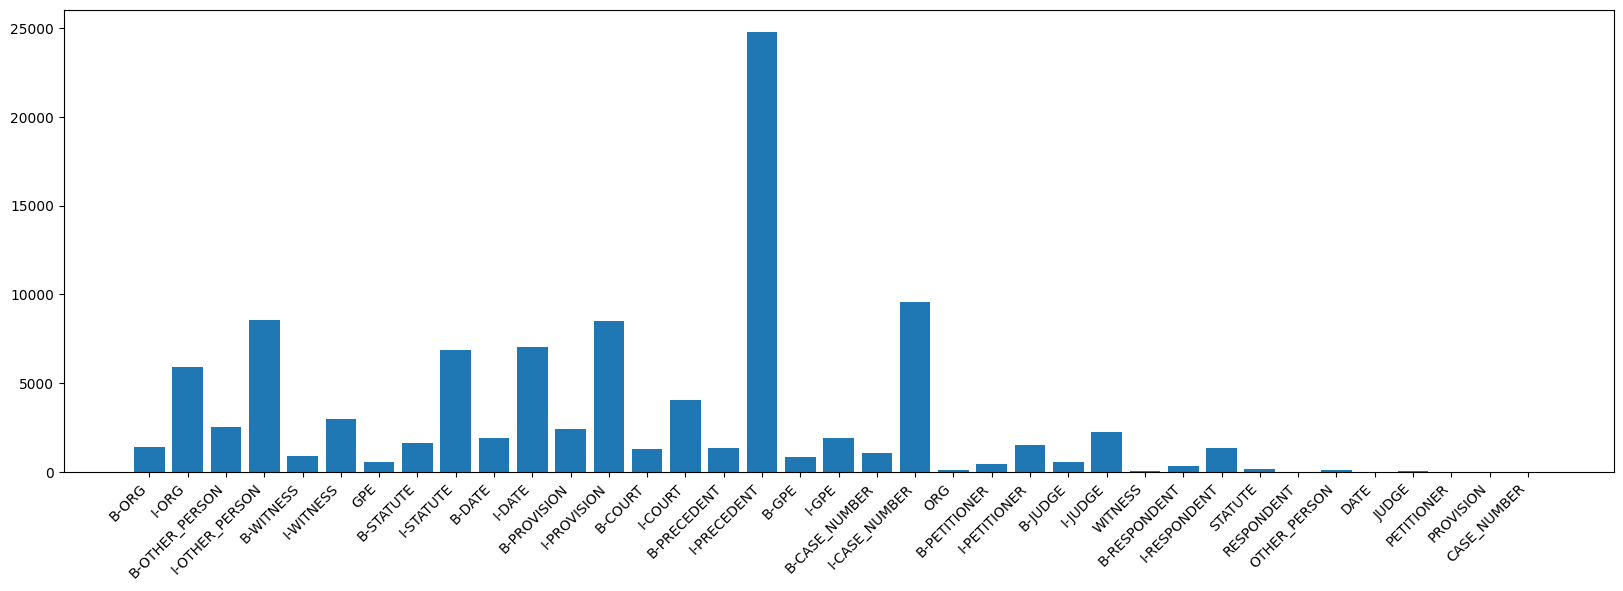

In [ ]:
import matplotlib.pyplot as plt

# data = ne_distribution.pop('O')
names = list(ne_distribution.keys())
values = list(ne_distribution.values())
plt.figure(figsize=(20,6))
plt.xticks(rotation=45, ha='right')

plt.bar(range(len(ne_distribution)), values, tick_label=names,)
plt.show()

In [ ]:
dev_distribution = {}
## objective: {'ne' : num_occ}
for labels in dev_tokens_labels:
  for idx in range(len(labels)):
    if labels[idx] in dev_distribution.keys():
      dev_distribution[labels[idx]] +=1
    else:
      dev_distribution[labels[idx]] = 1

print(len(dev_distribution ))
import pandas as pd

pd.DataFrame.from_dict(dict(sorted(dev_distribution.items(), key = lambda x: x[1])),  orient='index')

11


,0
B-COURT,118
B-JUDGE,159
B-PETITIONER,194
B-RESPONDENT,292
B-LAWYER,505
I-JUDGE,763
I-COURT,898
I-PETITIONER,1058
I-RESPONDENT,1856
I-LAWYER,2371


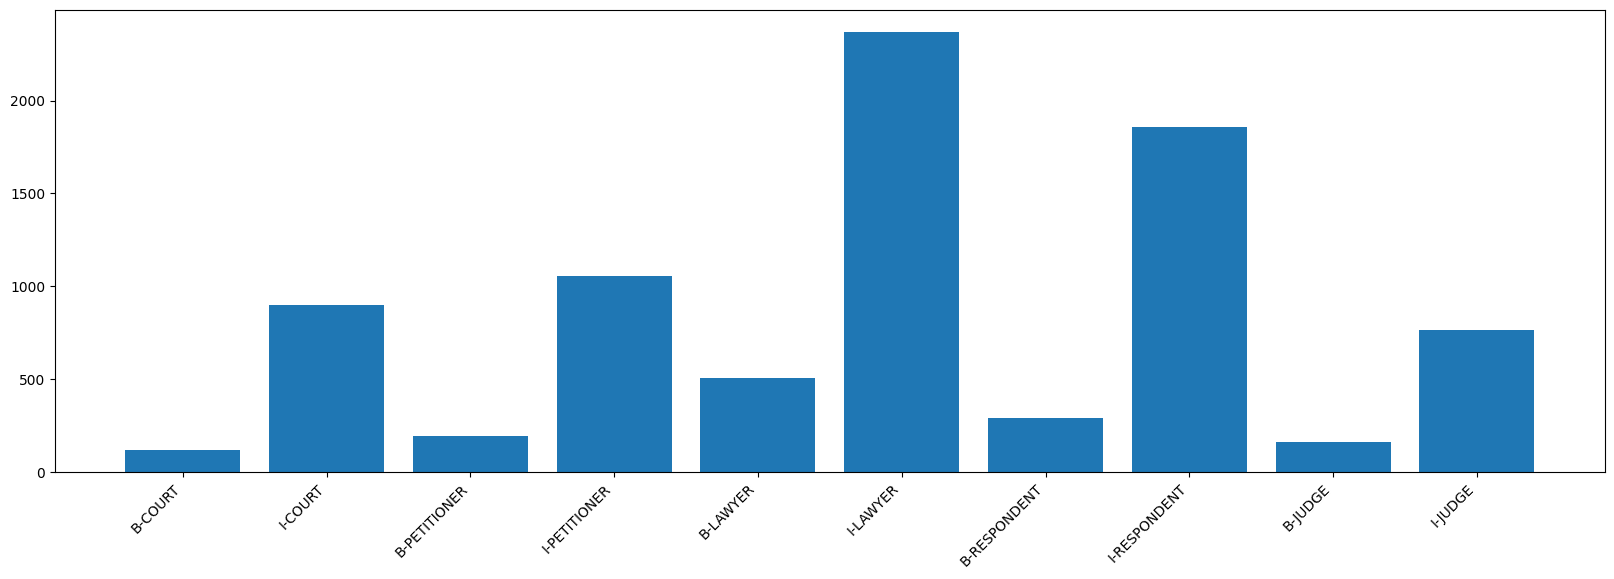

In [ ]:
import matplotlib.pyplot as plt
dev_distribution.pop('O')
# data = ne_distribution.pop('O')
names = list(dev_distribution.keys())
values = list(dev_distribution.values())
plt.figure(figsize=(20,6))
plt.xticks(rotation=45, ha='right')

plt.bar(range(len(dev_distribution)), values, tick_label=names,)
plt.show()

In [ ]:
sorted([elt for elt in results.keys()][:-4])

['CASE_NUMBER',
 'COURT',
 'DATE',
 'GPE',
 'JUDGE',
 'LAWYER',
 'ORG',
 'OTHER_PERSON',
 'PE',
 'PETITIONER',
 'PRECEDENT',
 'PROVISION',
 'RESPONDENT',
 'STATUTE']

In [ ]:
set([elt if elt in  results.keys() else None for elt in dev_distribution])

{None}

In [ ]:
set([elt if elt in  results.keys() else '' for elt in ne_distribution])

{'',
 'CASE_NUMBER',
 'DATE',
 'GPE',
 'JUDGE',
 'ORG',
 'OTHER_PERSON',
 'PETITIONER',
 'PROVISION',
 'RESPONDENT',
 'STATUTE'}

In [ ]:
set([elt if elt not in ne_distribution  else '' for elt in dev_distribution])

{'', 'B-LAWYER', 'I-LAWYER'}

#### labels

In [ ]:
set([elt if elt not in dev_distribution else '' for elt in ne_distribution])

{'',
 'B-CASE_NUMBER',
 'B-DATE',
 'B-GPE',
 'B-ORG',
 'B-OTHER_PERSON',
 'B-PRECEDENT',
 'B-PROVISION',
 'B-STATUTE',
 'B-WITNESS',
 'CASE_NUMBER',
 'DATE',
 'GPE',
 'I-CASE_NUMBER',
 'I-DATE',
 'I-GPE',
 'I-ORG',
 'I-OTHER_PERSON',
 'I-PRECEDENT',
 'I-PROVISION',
 'I-STATUTE',
 'I-WITNESS',
 'JUDGE',
 'ORG',
 'OTHER_PERSON',
 'PETITIONER',
 'PROVISION',
 'RESPONDENT',
 'STATUTE',
 'WITNESS'}